In [4]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from itertools import chain
from tensorflow.keras import layers
import matplotlib.pyplot as plt

import matplotlib.image as mpimg


# Suppress TensorFlow warnings for clarity
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

print("TensorFlow version:", tf.__version__)

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.1),  # Rotates images by a factor between -10% and +10%
    layers.RandomZoom(0.1),
])

labels_df = pd.read_csv('/Users/angel/OneDrive/Desktop/CS 4100/Satellite_Image_Classifier/data/train_v2.csv')
labels_df.head()

# Print all unique tags
# from itertools import chain
labels_list = list(chain.from_iterable([tags.split(" ") for tags in labels_df['tags'].values]))
labels_set = set(labels_list)

images_title = [labels_df[labels_df['tags'].str.contains(label)].iloc[i]['image_name'] + '.jpg' 
                for i, label in enumerate(labels_set)]

# plt.rc('axes', grid=False)
# _, axs = plt.subplots(5, 4, sharex='col', sharey='row', figsize=(15, 20))
# axs = axs.ravel()

# for i, (image_name, label) in enumerate(zip(images_title, labels_set)):
#     img = mpimg.imread('/Users/angel/OneDrive/Desktop/CS 4100/train-jpg/train-jpg' + '/' + image_name)
#     axs[i].imshow(img)
#     axs[i].set_title('{} - {}'.format(image_name, label))


TensorFlow version: 2.17.0


In [5]:
train_jpeg_dir = '/Users/angel/OneDrive/Desktop/CS 4100/train-jpg/train-jpg'
train_csv_file = '/Users/angel/OneDrive/Desktop/CS 4100/Satellite_Image_Classifier/data/train_v2.csv'
test_jpeg_dir = '/Users/angel/OneDrive/Desktop/CS 4100/test-jpg/test-jpg'
test_additional_jpeg_dir = '/Users/angel/OneDrive/Desktop/CS 4100/Satellite_Image_Classifier/data/test_v2_file_mapping.csv'
img_resize = (128, 128)  # Desired image size
validation_split = 0.2
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

# Step 1: Read Labels and File Paths
labels_df = pd.read_csv(train_csv_file)

# Step 2: Extract all unique labels
labels = sorted(set(chain.from_iterable([tags.split(" ") for tags in labels_df['tags'].values])))

# Step 3: Create a mapping from label to index
labels_map = {label: idx for idx, label in enumerate(labels)}
num_classes = len(labels_map)

# Step 4: Map Labels to Integers and One-Hot Encode
def encode_tags(tags_str):
    tags = tags_str.split(' ')
    targets = np.zeros(num_classes, dtype='float32')
    for tag in tags:
        targets[labels_map[tag]] = 1.0
    return targets

labels_df['targets'] = labels_df['tags'].apply(encode_tags)


In [6]:
# Step 5: Split Data into Training and Validation Sets
train_df, val_df = train_test_split(labels_df, test_size=validation_split, random_state=42)

# Reset indices
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

print(len(train_df), len(val_df))

32383 8096


In [7]:
# Step 6: Define the Pure Python Image Loading Function
def _load_image(path_str):
    """
    Load and preprocess an image from a given file path.

    Args:
        path_str (bytes): The file path as a bytes object.

    Returns:
        np.ndarray: The preprocessed image as a NumPy array.
    """
    try:
        from PIL import Image  # Import inside the function to ensure accessibility

        # Decode the bytes to a UTF-8 string
        path_str = path_str.decode('utf-8')

        # Open the image using PIL
        with Image.open(path_str) as img:
            # Convert image to RGB (handles CMYK and other modes)
            img = img.convert('RGB')
            # Resize the image
            img = img.resize(img_resize)
            # Convert to NumPy array and normalize to [0, 1]
            img_array = np.array(img).astype(np.float32) / 255.0
            # Normalize to [-1, 1]
            img_array = (img_array * 2.0) - 1.0

        return img_array
    except Exception as e:
        print(f"Error loading image {path_str}: {e}")
        # Return a zero tensor as a placeholder to prevent pipeline failure
        return np.zeros([img_resize[0], img_resize[1], 3], dtype=np.float32)

In [8]:
# Step 7: Define the TensorFlow Wrapper Function using tf.numpy_function
def load_and_preprocess_image_numpy(path, label):
    """
    TensorFlow wrapper for loading and preprocessing an image using tf.numpy_function.

    Args:
        path (tf.Tensor): The file path as a TensorFlow string tensor.
        label (tf.Tensor): The corresponding label tensor.

    Returns:
        tuple: A tuple of the preprocessed image tensor and label tensor.
    """
    # Use tf.numpy_function to apply the pure Python _load_image function
    image = tf.numpy_function(func=_load_image, inp=[path], Tout=tf.float32)

    # Set the shape of the image tensor
    image.set_shape([img_resize[0], img_resize[1], 3])

    return image, label

In [9]:
def augment_image(image, label):
    """
    Apply data augmentation to the image.
    
    Args:
        image (tf.Tensor): The input image tensor.
        label (tf.Tensor): The corresponding label tensor.
    
    Returns:
        tuple: The augmented image tensor and the original label tensor.
    """
    image = data_augmentation(image)
    return image, label

In [10]:
# Step 8: Define the Dataset Creation Function using tf.numpy_function
def create_dataset_numpy(df, training=True):
    """
    Create a TensorFlow dataset from a DataFrame using tf.numpy_function.

    Args:
        df (pd.DataFrame): DataFrame containing image paths and labels.
        training (bool): Whether the dataset is for training (enables shuffling).

    Returns:
        tf.data.Dataset: The prepared dataset.
    """
    # Construct full file paths
    image_paths = df['image_name'].apply(lambda x: os.path.join(train_jpeg_dir, f"{x}.jpg")).tolist()
    labels = np.stack(df['targets'].values)

    # Create a TensorFlow Dataset from the file paths and labels
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))

    # Map the load_and_preprocess_image_numpy function to the dataset
    dataset = dataset.map(load_and_preprocess_image_numpy, num_parallel_calls=AUTOTUNE)

    if training:
        # Shuffle the dataset for training
        dataset = dataset.shuffle(buffer_size=1000)
        # Apply data augmentation
        dataset = dataset.map(augment_image, num_parallel_calls=AUTOTUNE)

    # Batch and prefetch the dataset for optimal performance
    dataset = dataset.batch(batch_size).prefetch(AUTOTUNE)

    return dataset

In [11]:
# Step 9: Create Training and Validation Datasets using tf.numpy_function
train_dataset_numpy = create_dataset_numpy(train_df, training=True)
val_dataset_numpy = create_dataset_numpy(val_df, training=False)

#print(len(train_dataset_numpy),len (val_dataset_numpy))

# Step 10: Verify the Datasets
print("\nVerifying Training Dataset with tf.numpy_function:")
for images, labels in train_dataset_numpy.take(1):
    print("Image tensor shape:", images.shape)
    print("Image tensor dtype:", images.dtype)
    print("Image tensor min value:", tf.reduce_min(images).numpy())
    print("Image tensor max value:", tf.reduce_max(images).numpy())
    print("Image tensor mean value:", tf.reduce_mean(images).numpy())
    break


Verifying Training Dataset with tf.numpy_function:
Image tensor shape: (32, 128, 128, 3)
Image tensor dtype: <dtype: 'float32'>
Image tensor min value: -0.9998243
Image tensor max value: 0.88782966
Image tensor mean value: -0.32921365


In [12]:
# Step 12: Create Test Dataset using tf.numpy_function and PIL-based Loader
def load_and_preprocess_test_image_numpy(path):
    """
    TensorFlow wrapper for loading and preprocessing test images using tf.numpy_function.

    Args:
        path (tf.Tensor): The file path as a TensorFlow string tensor.

    Returns:
        tf.Tensor: The preprocessed image tensor.
    """
    # Use tf.numpy_function to apply the pure Python _load_image function
    image = tf.numpy_function(func=_load_image, inp=[path], Tout=tf.float32)

    # Set the shape of the image tensor
    image.set_shape([img_resize[0], img_resize[1], 3])

    return image

# Get test file paths
test_files = [os.path.join(test_jpeg_dir, f) for f in os.listdir(test_jpeg_dir)]

print(len(test_files))

# Create test dataset using the PIL-based loader
test_dataset = tf.data.Dataset.from_tensor_slices(test_files)
test_dataset = test_dataset.map(load_and_preprocess_test_image_numpy, num_parallel_calls=AUTOTUNE)
test_dataset = test_dataset.batch(batch_size).prefetch(AUTOTUNE)

# (Optional) Visualize Test Images Without Labels
num_test_images_to_display = 9
plt.figure(figsize=(10, 10))

for images in test_dataset.take(1):
    test_images_np = images.numpy()

    # Convert images from [-1, 1] to [0, 1] for visualization
    test_images_np = (test_images_np + 1.0) / 2.0
    break

print(len(test_images_np))

# for i in range(num_test_images_to_display):
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(test_images_np[i])
#     plt.axis("off")
# plt.tight_layout()
# plt.show()

40669
32


<Figure size 1000x1000 with 0 Axes>

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models

# Convert dataset into numpy arrays
x_train_data = []
y_train_data = []

x_test_data = []
y_test_data = []

for x_batch, y_batch in train_dataset_numpy:
    x_train_data.append(x_batch.numpy())  # Add images to list
    y_train_data.append(y_batch.numpy())  # Add labels to list

for x_batch, y_batch in val_dataset_numpy:
    x_test_data.append(x_batch.numpy())  # Add images to list
    y_test_data.append(y_batch.numpy())  # Add labels to list

# Concatenate to get all data
x_train_data = np.concatenate(x_train_data, axis=0)
y_train_data = np.concatenate(y_train_data, axis=0)
x_test_data = np.concatenate(x_test_data, axis=0)
y_test_data = np.concatenate(y_test_data, axis=0)

print("All images (x):", x_test_data.shape)
print("All labels (y):", y_test_data.shape)




All images (x): (8096, 128, 128, 3)
All labels (y): (8096, 17)


In [ ]:
print(y_test_data[0])
# Split the data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_resize[0], img_resize[1], 3)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='sigmoid')  # Use the number of unique classes
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(x_train_data, y_train_data, epochs=7, batch_size=batch_size, validation_split=0.2)


# print(f"Test accuracy: {accuracy}")
from sklearn.metrics import classification_report

# Predict on test data
y_pred_prob = model.predict(x_test_data)

# Create different probability thresholds depending on the amount of samples for each class
thresholds = [0.5, 0.1, 0.3, 0.1, 0.1, .5, .4, .1, .4, .4, .4,  .5, .5, .5, .2, .2, .5]  # Custom threshold for each class
predicted_classes = np.array([pred > threshold for pred, threshold in zip(y_pred_prob.T, thresholds)]).T.astype(int)

y_pred = (y_pred_prob > 0.5).astype(int)  # Threshold probabilities at 0.5

# Example of printing a prediction
# for i in range(5):  # Print first 5 predictions
#     print(f"Predicted class for test image {i}: {predicted_classes[i]} (Actual class: {y_train_data[i]})")

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0.]


c:\Users\angel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/7
810/810 ━━━━━━━━━━━━━━━━━━━━ 69s 84ms/step - accuracy: 0.0326 - loss: 0.2283 - val_accuracy: 0.0994 - val_loss: 0.1653
Epoch 2/7
810/810 ━━━━━━━━━━━━━━━━━━━━ 69s 85ms/step - accuracy: 0.0878 - loss: 0.1571 - val_accuracy: 0.1275 - val_loss: 0.1488
Epoch 3/7
810/810 ━━━━━━━━━━━━━━━━━━━━ 68s 85ms/step - accuracy: 0.0921 - loss: 0.1431 - val_accuracy: 0.0553 - val_loss: 0.1455
Epoch 4/7
810/810 ━━━━━━━━━━━━━━━━━━━━ 69s 85ms/step - accuracy: 0.0854 - loss: 0.1343 - val_accuracy: 0.0689 - val_loss: 0.1417
Epoch 5/7
810/810 ━━━━━━━━━━━━━━━━━━━━ 69s 86ms/step - accuracy: 0.0839 - loss: 0.1279 - val_accuracy: 0.0848 - val_loss: 0.1374
Epoch 6/7
810/810 ━━━━━━━━━━━━━━━━━━━━ 68s 85ms/step - accuracy: 0.0829 - loss: 0.1207 - val_accuracy: 0.0713 - val_loss: 0.1341
Epoch 7/7
810/810 ━━━━━━━━━━━━━━━━━━━━ 69s 85ms/step - accuracy: 0.0862 - loss: 0.1131 - val_accuracy: 0.0712 - val_loss: 0.1329
253/253 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step


In [153]:
print(classification_report(y_test_data, y_pred, target_names=labels_map))



                   precision    recall  f1-score   support

      agriculture       0.76      0.79      0.77      2441
   artisinal_mine       0.61      0.43      0.50        70
      bare_ground       0.83      0.03      0.06       175
         blooming       0.00      0.00      0.00        64
        blow_down       0.00      0.00      0.00        25
            clear       0.94      0.98      0.96      5728
           cloudy       0.90      0.68      0.77       395
conventional_mine       0.00      0.00      0.00        22
      cultivation       0.59      0.29      0.39       864
       habitation       0.53      0.58      0.55       743
             haze       0.75      0.50      0.60       533
    partly_cloudy       0.91      0.87      0.89      1440
          primary       0.96      1.00      0.98      7507
             road       0.65      0.83      0.73      1568
selective_logging       0.07      0.02      0.03        61
       slash_burn       0.00      0.00      0.00       

c:\Users\angel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\angel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [152]:
thresholds = [0.5, 0.15, 0.3, 0.15, 0.15, .5, .2, .03, .25, .45, .25, .4, .5, .5, .1, .06, .35]  # Custom threshold for each class
predicted_classes = np.array([pred > threshold for pred, threshold in zip(y_pred_prob.T, thresholds)]).T.astype(int)
print(classification_report(y_test_data, predicted_classes, target_names=labels_map))


                   precision    recall  f1-score   support

      agriculture       0.76      0.79      0.77      2441
   artisinal_mine       0.40      0.63      0.49        70
      bare_ground       0.52      0.07      0.13       175
         blooming       0.13      0.41      0.19        64
        blow_down       0.00      0.00      0.00        25
            clear       0.94      0.98      0.96      5728
           cloudy       0.78      0.86      0.82       395
conventional_mine       0.12      0.27      0.16        22
      cultivation       0.40      0.55      0.46       864
       habitation       0.49      0.62      0.55       743
             haze       0.61      0.65      0.63       533
    partly_cloudy       0.90      0.88      0.89      1440
          primary       0.96      1.00      0.98      7507
             road       0.65      0.83      0.73      1568
selective_logging       0.14      0.44      0.21        61
       slash_burn       0.09      0.09      0.09       

{'agriculture': {'precision': 0.7593984962406015, 'recall': 0.786153215895125, 'f1-score': 0.7725442834138486, 'support': 2441.0}, 'artisinal_mine': {'precision': 0.4, 'recall': 0.6285714285714286, 'f1-score': 0.4888888888888889, 'support': 70.0}, 'bare_ground': {'precision': 0.52, 'recall': 0.07428571428571429, 'f1-score': 0.13, 'support': 175.0}, 'blooming': {'precision': 0.12807881773399016, 'recall': 0.40625, 'f1-score': 0.1947565543071161, 'support': 64.0}, 'blow_down': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 25.0}, 'clear': {'precision': 0.9359638856378532, 'recall': 0.977304469273743, 'f1-score': 0.9561875480399693, 'support': 5728.0}, 'cloudy': {'precision': 0.7780320366132724, 'recall': 0.8607594936708861, 'f1-score': 0.8173076923076923, 'support': 395.0}, 'conventional_mine': {'precision': 0.11538461538461539, 'recall': 0.2727272727272727, 'f1-score': 0.16216216216216217, 'support': 22.0}, 'cultivation': {'precision': 0.40134907251264756, 'recall': 0.550

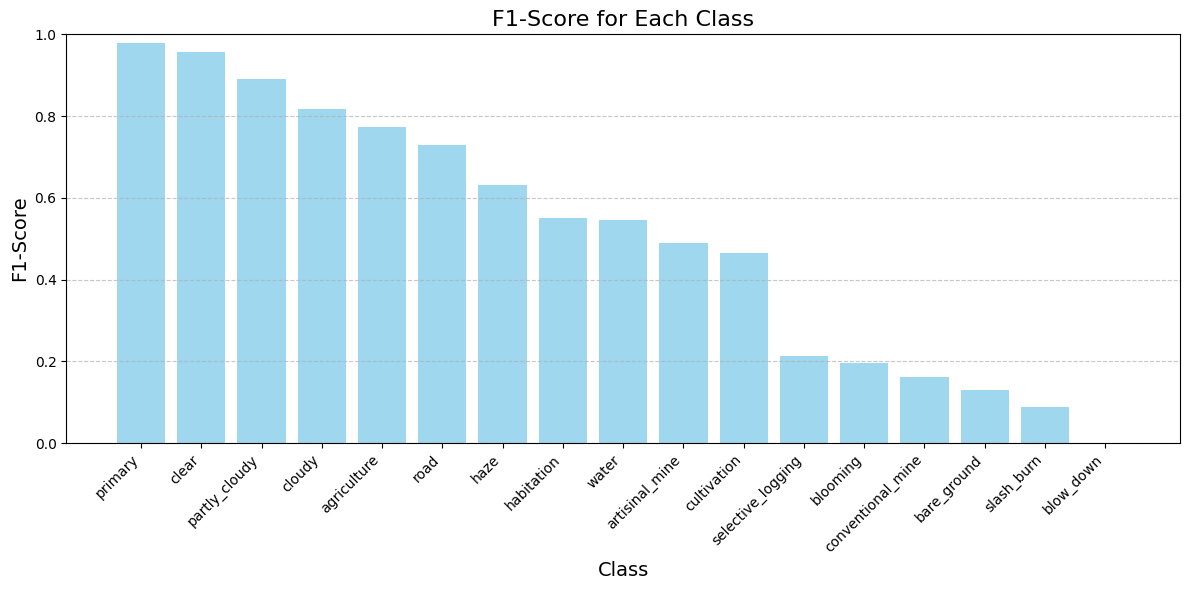

In [160]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import numpy as np

# Example classification report (dictionary format or generated from sklearn)
report = classification_report(y_test_data, predicted_classes, target_names=labels_map, output_dict=True)
print(report)
class_f1_scores = {
    k: v["f1-score"] for k, v in report.items() if k not in ["micro avg", "macro avg", "weighted avg", "samples avg"]
}

sorted_scores = sorted(class_f1_scores.items(), key=lambda item: item[1], reverse=True)  # Sort by F1 score descending
classes, f1_scores = zip(*sorted_scores)


plt.figure(figsize=(12, 6))
plt.bar(classes, f1_scores, color="skyblue", alpha=0.8)
plt.title("F1-Score for Each Class", fontsize=16)
plt.xlabel("Class", fontsize=14)
plt.ylabel("F1-Score", fontsize=14)
plt.ylim(0, 1)  # F1-scores range between 0 and 1
plt.xticks(rotation=45, ha="right")  # Rotate class names for better readability
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Hyperparameters
epochs = 1
learning_rate = 0.001
#num_classes = 10  # Set to the correct number of classes
img_resize = (128, 128)  # Replace with your actual image size


class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()

        # Convolutional Layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=0)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=0)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=0)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully Connected Layers
        self.fc1 = nn.Linear(128 * 14 * 14, 128)  # Flattened size = 128*14*14
        self.fc2 = nn.Linear(128, num_classes)  # Output size equals number of classes

    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))  # First Convolutional Layer
        x = self.pool2(torch.relu(self.conv2(x)))  # Second Convolutional Layer
        x = self.pool3(torch.relu(self.conv3(x)))  # Third Convolutional Layer

        x = x.view(-1, 128 * 14 * 14)  # Flatten the tensor
        x = torch.relu(self.fc1(x))  # First Fully Connected Layer
        x = self.fc2(x)  # Second Fully Connected Layer

        return x


# Initialize the model, loss function, and optimizer
model = CNNModel(num_classes).to(device)  # Send model to GPU
criterion = nn.BCEWithLogitsLoss()  # Binary Cross-Entropy Loss for multi-label tasks
optimizer = optim.Adam(model.parameters(), lr=0.001)

#y_train_data = y_train_data.view(-1, 17)

x_train_data_t = torch.tensor(x_train_data, dtype=torch.float32).permute(0, 3, 1, 2)
y_train_data_t = torch.tensor(y_train_data, dtype=torch.float32)

x_val_data_t = torch.tensor(x_test_data, dtype=torch.float32).permute(0, 3, 1, 2).to(device)
y_val_data_t = torch.tensor(y_test_data, dtype=torch.float32).to(device)

# x_train_data_t = DataLoader(x_train_data, batch_size=batch_size, shuffle=False)
# y_train_data_t = DataLoader(y_train_data, batch_size=batch_size, shuffle=False)
# Training the model
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for x_batch, y_batch in zip(x_train_data_t, y_train_data_t):
        # x_batch = torch.tensor(x_batch, dtype=torch.float32).permute(0, 3, 1, 2).to(device)
        # y_batch = torch.tensor(y_batch, dtype=torch.float32).to(device)
        #x_batch, y_batch = x_batch.to(device), y_batch.to(device)  # Send data to GPU
        
        optimizer.zero_grad()
        outputs = model(x_batch)
        y_batch = y_batch.unsqueeze(0)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    # Validation
    model.eval()
    val_loss = 0
    preds = []
    with torch.no_grad():
        for x_batch, y_batch in zip(x_val_data_t, y_val_data_t):
            val_outputs = model(x_batch)
            preds.append(val_outputs)
            y_batch = y_batch.unsqueeze(0)
            val_loss += criterion(val_outputs, y_batch).item()
    




In [63]:
thresholds = [0.5, 0.2, 0.3, 0.2, 0.2, .5, .4, .2, .4, .4, .4,  .5, .5, .5, .2, .2, .5]  # Custom threshold for each class
predicted_classes = np.array([pred > threshold for pred, threshold in zip(preds, thresholds)]).T.astype(int)
#predicted_classes2 = np.array([pred > threshold for pred, threshold in zip(preds, thresholds)]).T.astype(int)
from sklearn.metrics import classification_report

preds = [p.item() if isinstance(p, torch.Tensor) else p for p in preds]
predictions_tensor = torch.tensor(preds)

print(np.shape(preds))
# Flatten the test labels for comparison
print(classification_report(y_val_data_t, predictions_tensor, target_names=labels_map))
print(classification_report(y_val_data_t, predicted_classes, target_names=labels_map))

#print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss / len(x_train_data):.4f}, Val Loss: {val_loss / len(x_test_data):.4f}")

RuntimeError: a Tensor with 17 elements cannot be converted to Scalar